<h1><center>Tensor decomposition on binary data</center></h1> 

In [0]:
import scipy.io as sio
import numpy as np
import tensorly as tl
from tensorly.decomposition import tucker
import pandas as pd

In [18]:
#data = sio.loadmat('/My drive/Colab Notebooks/Country_Tensor/dnations')
data = data['R']
data.shape

(14, 14, 56)

In [19]:
data[np.isnan(data)] = 0
data[0,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

## Tucker decomposition to get initial value of G, A, B, C

$$
Y \longrightarrow 10(2Y-1)  = \hat{Y}
$$ 
Thus, we have:$$
\hat{Y}^{14*14*56} = G^{4*4*5} \times_1 A^{14*4}\times_2 B^{14*4} \times_3C^{56*5}
$$

## Matrix Form GLM

Consider 
$$
logit[E(Y))_{n*p}] = U_{n*p} = X_{n*R} \times \beta_{R*p}
$$
Where $U_{n*p} = (u_1,\ldots,u_p)$, $\beta_{R*p} = (\beta_1,\ldots, \beta_p)$

We have:
\begin{align*}
\begin{array}{c}
   u_1^{N*1} =  X^{n*R}\times \beta_1^{R*1} \\ 
   u_2^{N*1} =  X^{n*R}\times \beta_2^{R*1} \\ 
   \vdots\\
   u_p^{N*1} =  X^{n*R}\times \beta_P^{R*1}\\ 
\end{array}
\end{align*}
Then we implement GLM.

Then we use function to realize it:

In [0]:
from sklearn.linear_model import LogisticRegression
def glm_mat(U,X):
    p = U.shape[1]               # The columns of U i.e the number for X to replicate
    R = X.shape[1]               # The number of elements in each columns of beta_i (rows in beta)
    beta = np.arange(R).reshape(R,1)         ## initial beta_i to concatenate
    #print(beta)
    for i in np.arange(p):
        model = LogisticRegression(solver = 'liblinear', multi_class = 'ovr',fit_intercept = False)
        model.fit(X, U[:,i])
        beta_i = model.coef_.reshape(R,1)          ### beta_i : a R*1 vector
        #print(beta_i)
        beta = np.concatenate((beta, beta_i),axis = 1)
    ## Now beta is a R*(p+1) matrix with first column need to drop
    beta = beta[:,1:p+1]                ### drop initial column
    return beta  

In [21]:
b = np.array([1,0,0,1,1,0]).reshape(3,2)
b

array([[1, 0],
       [0, 1],
       [1, 0]])

In [22]:
c = np.arange(9).reshape(3,3)
c

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [23]:
glm_mat(b,c)

array([[-0.06988849,  0.06988849],
       [ 0.02955993, -0.02955993],
       [ 0.12900836, -0.12900836]])

## updating method:
### When updating A,B,C

$$
Y^{14*14*56} = G^{4*4*5} \times_1 A^{14*4}\times_2 B^{14*4} \times_3C^{56*5} = G_{AB}^{14*14*5} \times_3 C^{56*5} \\
$$
Update A,B,C through:
$$
Y_{(3)}^T =  G_{AB(3)}^T C^T
$$
Since for distinct modes in a series of multiplications, the order of the multiplication is irrelevant. Thus, A,B,C the same update way.


### When updating G
##### some calculation:

Consider$$
Y^{d_1*d_2*d_3} = G^{r_1*r_2*r_3} \times_1 A^{d_1*r_1}\times_2 B^{d_2*r_2} \times_3C^{d_3*r_3}
$$
We have:
$$
Y_{ijk} = \sum_{k'=1}^{r_3}\sum_{j'=1}^{r_2}\sum_{i'=1}^{r_1} G_{i'j'k'}A_{ii'}B_{jj'}C_{kk'}
$$
Let $$[M^{ijk}]_{i'j'k'} = A_{ii'}B_{jj'}C_{kk'}$$
$i = 1,\ldots, d_1;j = 1,\ldots, d_2; k = 1,\ldots, d_3$ There are $d_1*d_2*d_3$ $M^{ijk}$ tensors totally.The dimension of $M^{ijk}$ is $r_1*r_2*r_3$.

Then we have:
$$
Y_{ijk} = \sum_{k'=1}^{r_3}\sum_{j'=1}^{r_2}\sum_{i'=1}^{r_1} G_{i'j'k'}M^{ijk}_{i'j'k'}
$$

##### Vectorization:
Then we define a vectorization of the tensor in this scenario:
When we say vectorize a tensor G (3 dimension), we extract all its mode-3 fiber and then list it according first mode-2 then according to mode-1. In other words, when we count the vector elements, the element's third mode index change first, then second mode index, finally first mode index.

Here is a small example for understanding:
$$
Vec(G^{2*2*2}) = 
\left[\begin{array}{c}
G_{111}\\
G_{112}\\
G_{121}\\
G_{122}\\
G_{211}\\
G_{212}\\
G_{221}\\
G_{222}
\end{array}\right]
$$

The reason why we define like this is this is how reshape(-1) works.

In python: Vec(G) = G.reshape(-1).

In [0]:
a = tl.tensor(np.arange(24).reshape((3, 4, 2)))  ##
a[:,:,0]

array([[ 0,  2,  4,  6],
       [ 8, 10, 12, 14],
       [16, 18, 20, 22]])

In [0]:
b = a.reshape(-1)   ### Vec(a)
b

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [0]:
b.reshape(3,4,2)[:,:,0]

array([[ 0,  2,  4,  6],
       [ 8, 10, 12, 14],
       [16, 18, 20, 22]])

Recalling  $$[M^{ijk}]_{i'j'k'} = A_{ii'}B_{jj'}C_{kk'}$$

We have 
\begin{align}
Vec(M^{ijk}) = 
\left[\begin{array}{c}
A_{i1}B_{j1}C_{k1}\\
A_{i1}B_{j1}C_{k2}\\
\vdots\\
A_{i1}B_{j1}C_{kr_3}\\
\vdots\\
\vdots\\
A_{i1}B_{j2}C_{k1}\\
A_{i1}B_{j2}C_{k2}\\
\vdots\\
A_{i1}B_{j2}C_{kr_3}\\
\vdots\\
\vdots\\
A_{ir_1}B_{jr_2}C_{k1}\\
A_{ir_1}B_{jr_2}C_{k2}\\
\vdots\\
A_{ir_1}B_{jr_2}C_{kr_3}
\end{array}\right]_{r_1r_2r_3*1}  =
A_{i:} \otimes B_{j:} \otimes C_{k:}
\end{align}

The kronecker decomposition is consistent with the python code tl.tenalg.kronecker.

Then we have:$$
Y_{ijk} = \sum_{k'=1}^{r_3}\sum_{j'=1}^{r_2}\sum_{i'=1}^{r_1} G_{i'j'k'}M^{ijk}_{i'j'k'}\\
=Vec(G)^TVec(M^{ijk}) = Vec(M^{ijk})^T_{1*r_1r_2r_3}Vec(G)_{r_1r_2r_3*1}
$$

First step:
\begin{align*}
Y_{ij:} =
\left[\begin{array}{c}
y_{ij1}\\
y_{ij2}\\
\vdots\\
y_{ijd_3}\\
\end{array}\right]_{d_3*1}  =
\left[\begin{array}{c}
 Vec(M^{ij1})^T\\
 Vec(M^{ij2})^T\\
\vdots\\
 Vec(M^{ijd_3})^T\\
\end{array}\right]_{d_3*r_1r_2r_3} \times
Vec(G)_{r_1r_2r_3*1} = 
 Vec(M_{ijd_3})\times Vec(G)
\end{align*}

Second step:
\begin{align*}
Y_{i::} =
\left[\begin{array}{c}
y_{i1:}\\
y_{i2:}\\
\vdots\\
y_{id_2:}\\
\end{array}\right]_{d_2d_3*1}  =
\left[\begin{array}{c}
 Vec(M_{i1d_3})\\
 Vec(M_{i2d_3})\\
\vdots\\
 Vec(M_{id_2d_3})\\
\end{array}\right]_{d_2d_3*r_1r_2r_3} \times
Vec(G)_{r_1r_2r_3*1} = 
 Vec(M_{id_2d_3})\times Vec(G)
\end{align*}

Final step:
\begin{align*}
Y_{:::} =
\left[\begin{array}{c}
y_{1::}\\
y_{2::}\\
\vdots\\
y_{d_1::}\\
\end{array}\right]_{d_1d_2d_3*1}  =
\left[\begin{array}{c}
 Vec(M_{1d_2d_3})\\
 Vec(M_{2d_2d_3})\\
\vdots\\
 Vec(M_{d_1d_2d_3})\\
\end{array}\right]_{d_1d_2d_3*r_1r_2r_3} \times
Vec(G)_{r_1r_2r_3*1} =
M^{long}_{d_1d_2d_3*r_1r_2r_3} \times
Vec(G)_{r_1r_2r_3*1}
\end{align*}
Where $Y_{:::}$ is the Vec(Y) vectorization of Y we defined brfore.

In [0]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

def update_binary(data,core_shape, Nsim):
    data1 = 10*(2*data - 1)
    core, factors = tucker(data1,ranks=core_shape)
    Y_1 = tl.unfold(data,mode = 0)
    Y_2 = tl.unfold(data,mode = 1)
    Y_3 = tl.unfold(data,mode = 2)        ## get three unfold matrix
    A = factors[0]   ## 14*4   d1*r1
    B = factors[1]   ## 14*4   d2*r2
    C = factors[2]   ## 56*5   d3*r3
    G = core
    d1 = data.shape[0] ; d2 = data.shape[1] ; d3 = data.shape[2]  
    r1 = core_shape[0] ; r2 = core_shape[1] ; r3 = core_shape[2] 
    
    ### kind of a flaw  since Y_3 some columns are all zero
    #Y_3[0,np.where(Y_3.sum(0) == 0)] = 1
    ###
    
    loss_A = np.ones(Nsim)
    loss_B = np.ones(Nsim)
    loss_C = np.ones(Nsim)
    loss_G = np.ones(Nsim)
    for n in np.arange(Nsim):
        G_AB = tl.tenalg.multi_mode_dot(G,factors[:2],modes = [0,1])     ##  14*14*5    d1,d2,r3
        G_AC = tl.tenalg.multi_mode_dot(G,factors[0::2],modes = [0,2])   ## 14*4*56     d1,r2,d3
        G_BC = tl.tenalg.multi_mode_dot(G,factors[1:],modes = [1,2])     ## 4*14*56     r1,d2,d3
        
        ###### update A
        G_BC_1 = tl.unfold(G_BC,mode = 0)
        #print(G_BC.shape)
        A = glm_mat(Y_1.transpose(),G_BC_1.transpose()).transpose()
        ## cross_entropy loss when update A
        prob_A = sigmoid(A.dot(G_BC_1)).reshape(-1)
        loss_A[n] = log_loss(Y_1.reshape(-1),prob_A)
        
        ## update B
        G_AC_2 = tl.unfold(G_AC,mode = 1)
        #print(Y_2.shape)
        B = glm_mat(Y_2.transpose(),G_AC_2.transpose()).transpose()
        ## cross_entropy loss when update B
        prob_B = sigmoid(B.dot(G_AC_2)).reshape(-1)
        loss_B[n] = log_loss(Y_2.reshape(-1),prob_B)
    
        ## update C
        G_AB_3 = tl.unfold(G_AB,mode = 2)
        C = glm_mat(Y_3.transpose(),G_AB_3.transpose()).transpose()
        ## cross_entropy loss when update C
        prob_C = sigmoid(C.dot(G_AB_3)).reshape(-1)
        loss_C[n] = log_loss(Y_3.reshape(-1),prob_C)
        
        ## update G
        ## construct M^long
        M_long = np.arange(r1*r2*r3).reshape(1,-1)    ## With initial row
        for i in np.arange(d1):
            for j in np.arange(d2):
                for k in np.arange(d3):
                    Vec_M_ijk = tl.tenalg.kronecker((A[i,:],B[j,:],C[k,:])).reshape(1,-1)  
                    M_long = np.concatenate((M_long,Vec_M_ijk), axis = 0)
                              
        ##  Now M_long is a (d1d2d3+1)*r1r2r3 matrix with first row need to drop
        M_long = M_long[1:d1*d2*d3 + 1,:]
        model = LogisticRegression(solver = 'liblinear', multi_class = 'ovr',fit_intercept = False)
        model.fit(M_long, data.reshape(-1))
        G_new_vec = model.coef_
        
        ## cross_entropy loss when update G
        Net_input = M_long.dot(G_new_vec.reshape(-1,1))           ## shape = (d1d2d3,1)
        # print(Net_input.shape)
        prob = sigmoid(Net_input).reshape(-1)
        loss_G[n] = log_loss(data.reshape(-1),prob)   ### cross_entropy loss
        
        G_new = G_new_vec.reshape(r1,r2,r3)

        
        G = G_new

     
    factors = [A,B,C]
    return G,factors, loss_A,loss_B,loss_C, loss_G    
    

In [0]:
core, membership,loss_A,loss_B,loss_C, loss_G= update_binary(data,[4,4,5],100)

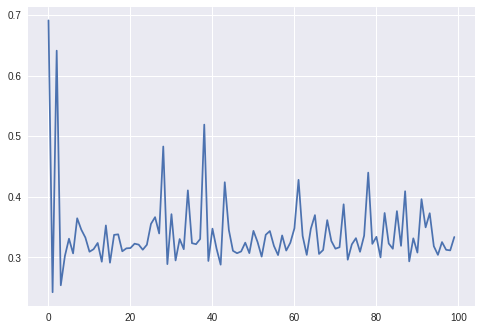

In [39]:
plt.plot(loss_G)

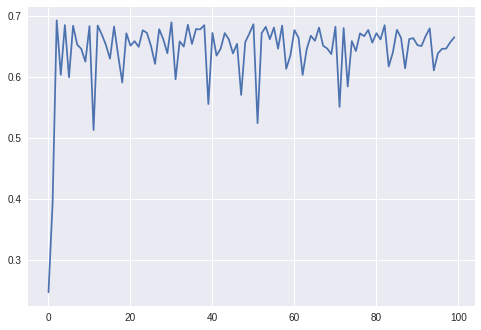

In [44]:
plt.plot(loss_A)

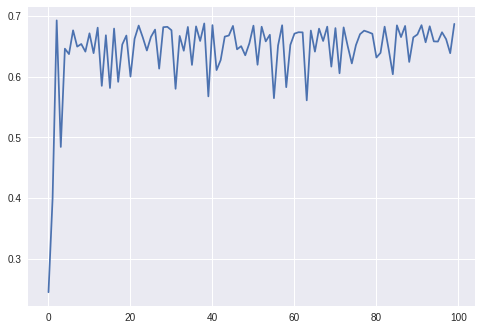

In [45]:
plt.plot(loss_B)

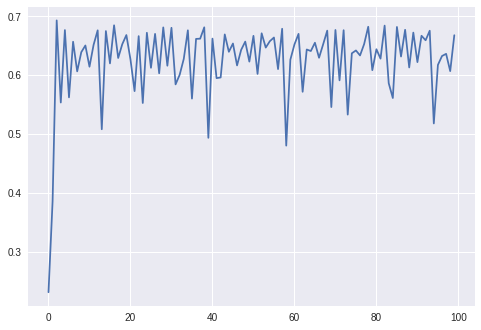

In [46]:
plt.plot(loss_C)

## Kmeans to cluster

In [47]:
from sklearn.cluster import KMeans
km0 = KMeans(n_clusters=4, random_state=0)
km0.fit(membership[0])

km1 = KMeans(n_clusters=4, random_state=0)
km1.fit(membership[1])

km2 = KMeans(n_clusters=5, random_state=0)
km2.fit(membership[2])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [48]:
pd.get_dummies(km0.labels_)

,0,1,2,3
0,0,0,0,1
1,1,0,0,0
2,0,1,0,0
3,0,1,0,0
4,0,0,0,1
5,1,0,0,0
6,1,0,0,0
7,0,0,1,0
8,1,0,0,0
9,1,0,0,0


In [49]:
pd.get_dummies(km1.labels_)

,0,1,2,3
0,0,0,1,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,0,0,0,1
5,0,0,0,1
6,1,0,0,0
7,0,0,0,1
8,1,0,0,0
9,0,0,1,0


In [50]:
pd.get_dummies(km2.labels_)

,0,1,2,3,4
0,0,1,0,0,0
1,0,1,0,0,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,1,0,0,0
5,0,0,1,0,0
6,0,1,0,0,0
7,0,1,0,0,0
8,0,0,0,1,0
9,0,0,0,1,0


In [51]:
sigmoid(core)

array([[[0.23040131, 0.79568792, 0.60476783, 0.29642202, 0.62151894],
        [0.76617443, 0.24638435, 0.77216055, 0.47653046, 0.42685494],
        [0.10759935, 0.65053712, 0.37541711, 0.34030052, 0.0786942 ],
        [0.62104103, 0.47802681, 0.67123443, 0.45812244, 0.76506257]],

       [[0.40941388, 0.72771747, 0.60649016, 0.45379537, 0.5942125 ],
        [0.46789689, 0.49655215, 0.30817662, 0.54606337, 0.52088307],
        [0.48887085, 0.81961843, 0.74895568, 0.53473914, 0.42824067],
        [0.51023109, 0.54371961, 0.52809702, 0.55731914, 0.59157515]],

       [[0.36964705, 0.7438162 , 0.63918409, 0.36701051, 0.48019278],
        [0.40359276, 0.36539355, 0.55584618, 0.44366223, 0.68579285],
        [0.44732298, 0.77022963, 0.61867797, 0.53121487, 0.18481509],
        [0.53921243, 0.58211479, 0.57173933, 0.5446978 , 0.68794779]],

       [[0.56107064, 0.69054124, 0.58628834, 0.41487108, 0.45325991],
        [0.26180569, 0.38738231, 0.66298455, 0.48964086, 0.67391201],
        [0.634